[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Shape: (50000, 2)
Tópico 1:  ['people', 'watch', 'time', 'movies', 'really', 'bad', 'good', 'film', 'like', 'movie']
Tópico 2:  ['best', 'time', 'character', 'like', 'love', 'story', 'good', 'great', 'movie', 'film']
Tópico 3:  ['way', 'life', 'characters', 'films', 'time', 'people', 'like', 'story', 'movie', 'film']
Tópico 4:  ['story', 'life', 'old', 'black', 'films', 'time', 'young', 'like', 'man', 'film']
Tópico 5:  ['police', 'house', 'episode', 'killer', 'time', 'good', 'like', 'gets', 'film', 'man']

RandomForest Results:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5000
           1       0.86      0.84      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85 

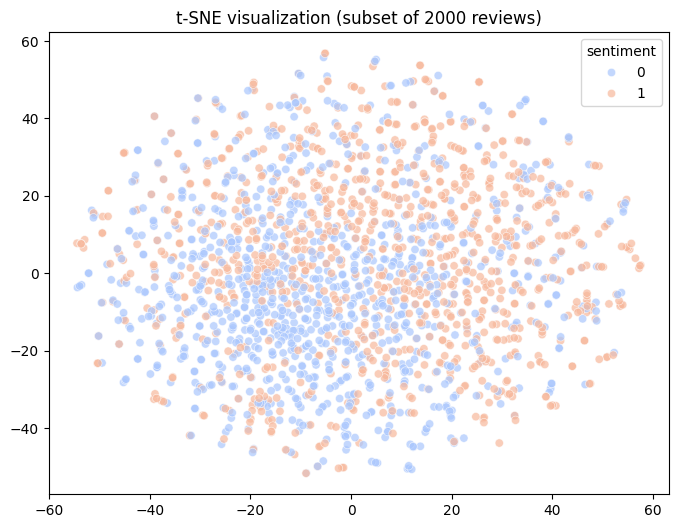

Review original: Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"
Predicted: negative


 96%|=================== | 191/200 [00:18<00:00]       

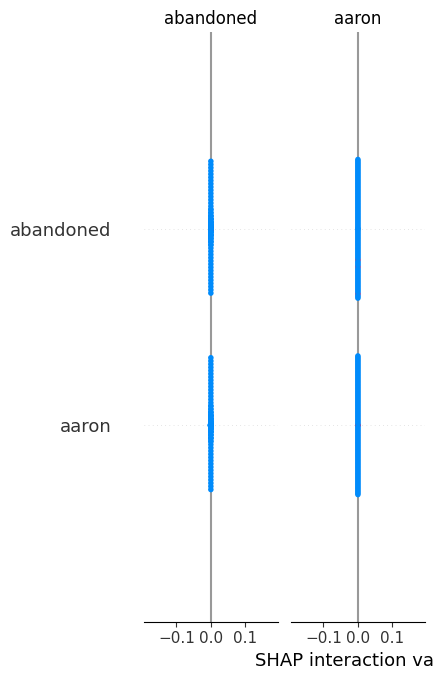

In [ ]:
# ===========================
# IMPORTS PRINCIPAIS
# ===========================
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import shap
import lime
from lime.lime_text import LimeTextExplainer

import kagglehub


# ===========================
# CARREGAR DATASET
# ===========================
# Baixar o dataset IMDB via kagglehub
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Path to dataset files:", path)

# Carregar CSV
csv_path = f"{path}/IMDB Dataset.csv"
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


# ===========================
# LIMPEZA DE TEXTO
# ===========================
def clean_text(text):
    """
    Remove HTML tags, números e caracteres especiais,
    converte para lowercase e remove stopwords.
    """
    text = re.sub(r"<.*?>", " ", text)  # remove tags HTML
    text = re.sub(r"[^a-zA-Z]", " ", text)  # mantém só letras
    text = text.lower()
    tokens = [w for w in text.split() if w not in STOPWORDS and len(w) > 2]
    return " ".join(tokens)

df["clean_review"] = df["review"].apply(clean_text)


# ===========================
# MODELAGEM DE TÓPICOS COM LDA
# ===========================
# Criar Bag of Words (contagem) para LDA
bow_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
bow = bow_vectorizer.fit_transform(df["clean_review"])

# Aplicar LDA do scikit-learn
n_topics = 5  # número de tópicos
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(bow)

# Função para exibir os principais termos de cada tópico
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"Tópico {idx+1}: ", [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-top_n:]])

print_topics(lda, bow_vectorizer)


# ===========================
# CRIAÇÃO DE FEATURES TF-IDF PARA CLASSIFICAÇÃO
# ===========================
tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X = tfidf.fit_transform(df["clean_review"])
y = df["sentiment"].map({"positive": 1, "negative": 0})  # map para 0/1

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# ===========================
# CLASSIFICAÇÃO COM RANDOM FOREST
# ===========================
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Avaliar desempenho
print("\nRandomForest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


# ===========================
# CLASSIFICAÇÃO COM XGBOOST
# ===========================
xgb = XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\nXGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))


# ===========================
# VISUALIZAÇÃO COM t-SNE
# ===========================
# Para performance, usa apenas uma amostra
X_embedded = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X[:2000].toarray())
y_subset = y[:2000]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y_subset, palette="coolwarm", alpha=0.7
)
plt.title("t-SNE visualization (subset of 2000 reviews)")
plt.show()


# ===========================
# EXPLICABILIDADE COM LIME
# ===========================
class_names = ["negative", "positive"]
explainer = LimeTextExplainer(class_names=class_names)

# Wrapper para transformar texto cru -> TF-IDF -> predição
def rf_predict_proba(texts):
    return rf.predict_proba(tfidf.transform(texts))

# Escolher índice de teste
idx = 10
exp = explainer.explain_instance(
    df["review"].iloc[idx],  # texto original
    rf_predict_proba,
    num_features=10
)

print("Review original:", df["review"].iloc[idx])
print("Predicted:", class_names[rf.predict(tfidf.transform([df['review'].iloc[idx]])).item()])
exp.show_in_notebook(text=True)


# ===========================
# EXPLICABILIDADE COM SHAP
# ===========================
# Usar amostra para performance
X_train_sample = X_train[:500].toarray()
X_test_sample = X_test[:100].toarray()

# Criar explainer SHAP
explainer_shap = shap.Explainer(rf, X_train_sample)
shap_values = explainer_shap(X_test_sample)

# Summary plot das features mais importantes
shap.summary_plot(shap_values, X_test_sample, feature_names=tfidf.get_feature_names_out())



# ==================================
# ANÁLISE DOS RESULTADOS E CONCLUSÕES
# ==================================

# 1. Sobre o Desempenho dos Modelos de Classificação
# ---------------------------------------------------
# - Os modelos (Random Forest e XGBoost) atingiram alta performance (acurácia de ~86% e ROC-AUC de ~0.93),
#   indicando que são capazes de distinguir entre reviews positivos e negativos com grande eficácia.
#
# - O XGBoost apresentou um desempenho ligeiramente superior ao Random Forest em todas as métricas,
#   reforçando sua reputação como um algoritmo robusto para dados tabulares (como a matriz TF-IDF).
#
# - A representação de texto via TF-IDF, mesmo sendo uma técnica clássica, mostrou-se muito eficaz
#   para capturar as informações necessárias para a tarefa de análise de sentimentos.

# 2. Sobre a Visualização com t-SNE
# ----------------------------------
# - O gráfico t-SNE confirma visualmente que os sentimentos positivo e negativo são, em grande parte,
#   separáveis no espaço de features. Existem regiões claras onde uma classe predomina sobre a outra.
#
# - A sobreposição observada entre os dois grupos no gráfico justifica por que a acurácia dos modelos
#   não é de 100%, evidenciando a complexidade e a ambiguidade inerentes à linguagem natural.

# 3. Sobre a Interpretabilidade com LIME (Análise Local)
# -------------------------------------------------------
# - A análise com LIME demonstrou ser possível explicar o porquê de uma previsão individual.
#   Ela identifica as palavras exatas que mais contribuíram para a classificação de um único review.
#
# - Para o exemplo analisado, palavras como "problem", "low" e "budget" foram determinantes para a
#   previsão "negativa", superando o impacto de palavras positivas como "better" e "interesting".

# 4. Sobre a Interpretabilidade com SHAP (Análise de Interação)
# ------------------------------------------------------------
# - O gráfico de interação SHAP indicou que não há um efeito de interação significativo entre as
#   palavras "abandoned" e "aaron".
#
# - Isso significa que a contribuição dessas palavras para a previsão do modelo é aditiva e
#   independente, ou seja, o efeito de uma não é alterado pela presença da outra.

# 5. Sobre a Análise Exploratória com LDA (Modelagem de Tópicos)
# ---------------------------------------------------------------
# - A modelagem de tópicos com LDA revelou a existência de temas latentes e distintos no corpus,
#   como "discussões gerais sobre filmes", "narrativa e personagens" e até mesmo possíveis
#   gêneros como "crime/suspense", fornecendo um bom entendimento do conteúdo dos dados.

# 6. Conclusão Geral do Projeto
# -----------------------------
# - O projeto validou com sucesso um pipeline completo de NLP, desde o pré-processamento até a
#   interpretabilidade, mostrando que modelos de Machine Learning tradicionais são uma forte
#   baseline para tarefas de classificação de texto.
#
# - As ferramentas de explicabilidade (LIME e SHAP) foram essenciais para ir além das métricas
#   de performance, permitindo uma compreensão mais profunda de como o modelo toma suas decisões,
#   o que é crucial para a confiança e a validação do sistema.
